# Initalization

In [2]:
# Import modules and set the calibration image path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline


cal_img_dir = "./camera_cal"
cal_img_fname_general = os.path.join(cal_img_dir,"calibration{}.jpg")

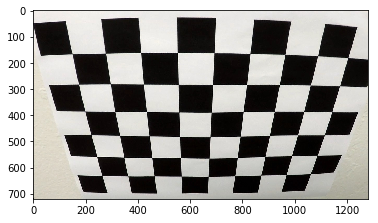

In [3]:
img_path = cal_img_fname_general.format(2)
img = plt.imread(img_path)
plt.imshow(img)

# Undistort an image

<img src="img_ref/objpoints_description.png" style="width:760px;height:402;"> <br>

Obeject points are coordinates of the chessboard points in the real world. The z-coordinate will stay 0 and x and y coordinates are as shown in the image above. The image above is misleading because in out case, there should be 6 
rows and 8 columns. The image only has 5 rows and 7 columns. (The outter corners are not counted towards the number of corners)

In [5]:
def findChessboardCorners_wrapper(img,nxny=(9,6)):
    nx,ny = nxny
    # --- convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # --- Find the chessboard corners
    # ret is simply a boolean return value that is true if the corners are found and false if otherwise
    foundCorners, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If the input (nx,ny) are not true, iterate to find nx,ny
    # inclusive range
    nx_range=(6,9)
    ny_range=(4,6)
    nx_it = nx_range[0]
    ny_t = ny_range[0]
    while not foundCorners and nx_it <= nx_range[-1]:
        foundCorners, corners = cv2.findChessboardCorners(gray, (nx_it,ny_it), None)
        
        if not foundCorners:
            ny_it += 1
            if ny_it > ny_range[1]:
                ny_it = ny_range[0]
                nx_it += 1
        else:
            nx = nx_it
            ny = ny_it
    
    
    if foundCorners:
        # --- Prepare object points, (0,0,0), (1,0,0), (2,0,0), ... , (7,5,0)
        # initialize nx X ny of 3-tuples (x,y,z) with all zeros 
        objp = np.zeros((nx*ny,3),np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        cornerDim = (nx,ny)
        return corners, objp, cornerDim
    
    else:
        return None,None,None

I noticed the number of corners in each image differs by a little depending on how to image was cropped. Therefore, I will start with an initial guess value of nx = 7 and ny = 4 and do a grid search to nx_max = 9 and ny_max = 6. For some reason, the chessboard corners for the "calibration4.jpg" could not be found. I discarded the image.

In [7]:
import glob
# Read in and make a list of calibration image paths
img_paths = glob.glob(cal_img_fname_general.format("*"))

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in imagNe plane
img_list = [] 
cornerDim = [(9, 5),(9, 6),(9, 6),(9, 6),(9, 6),(8, 6),(9, 6),(9, 6),(9, 6),(9, 6),
             (9, 6),(7, 4),(9, 6),(9, 6),(7, 6),(9, 6),(9, 6),(9, 6),(9, 6)] # array of (nx,ny) tuples

nxny_list = []

# img_path = "./camera_cal/calibration4.jpg"
# img = plt.imread(img_path)
# plt.imshow(img)
# corners, objp, nxny_ret = findChessboardCorners_wrapper(img,(9,6))
# print(nxny_ret)
for img_path,nxny in zip(img_paths,cornerDim):

    img = plt.imread(img_path)
    
    corners, objp, nxny_ret = findChessboardCorners_wrapper(img,nxny)
    img_list.append(img)
    objpoints.append(objp)
    imgpoints.append(corners)
    nxny_list.append(nxny_ret)



# Calibration

In [8]:
def calibrate_wrapper(objpoint,imgpoint,img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    if ret:
        return mtx,dist
    else:
        return None,None
    

In [9]:
ii =0 
mtx_list = []
dist_list = []
for objpoint,imgpoint,img in zip(objpoints,imgpoints,img_list):
    mtx,dist = calibrate_wrapper(objpoint,imgpoint,img)
    
    mtx_list.append(mtx)
    dist_list.append(dist)

### Find the Mean of the Camera Matrix (mtx) and the Distortion Coefficient (dist)
The camera matrix and distortion coefficient should be very similar for all the images

In [10]:
mtx_ave = np.mean(mtx_list,axis=0)
dist_ave = np.mean(dist_list,axis=0)

#### Undistort few of the original images

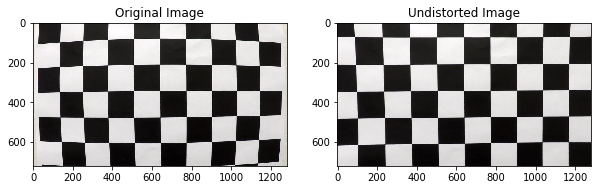

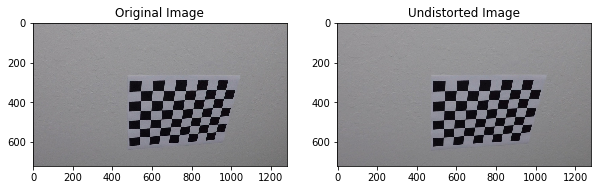

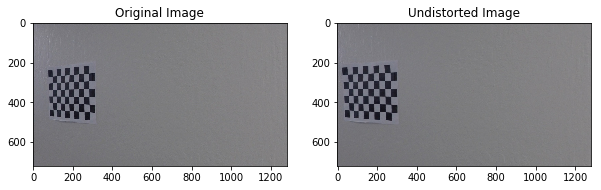

In [11]:
img_list_example = np.copy(img_list) # make a deep copy

for img in img_list_example[:3]:
    img_undistort = cv2.undistort(img,mtx_ave,dist_ave,None,mtx_ave)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1,2,2)
    plt.imshow(img_undistort)
    plt.title("Undistorted Image")


# Load Example Road Imgs

In [ ]:
img_road =  

# Sobel Operator
Using the Sobel operators, find the Sobel_x and Sobel_y

In [12]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output